# Threading in Python

1. Definition of threading, concurrency, parallelism
2. Quick overview of `threading`, `.Thread`, `.Lock`, `.RLock`, `.Event`, `queue`
3. Quick overview of `multiprocessing`, `.Process`, `.Pool`, `.Queue`, `.dummy`
4. Examples using `threading`
5. Examples using `multiprocessing`, `multiprocessing.dummy`
6. Difficulties in using these directly
7. 3rd party libs:
    - dask
    - ipyparallel
    - zmq
8. Best practices
9. Recap
10. Questions?

# What is threading?

Threads are essentially different sequences of instructions that are run concurrently.  In Python, threads within a single process share the same CPU and memory resources (although this can be dangerous if not done carefully).

# Concurrency vs Parallelism

Concurrency is where multiple distinct sequences of instructions are run in a given time period, usually through techniques such as context switching:

In [4]:
%matplotlib inline
from itertools import cycle
import matplotlib.pyplot as plt
plt.xkcd();

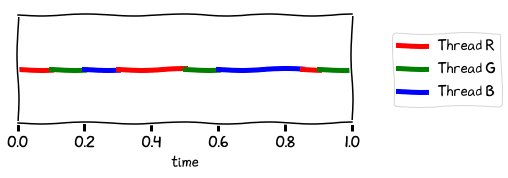

In [8]:
plt.figure(figsize=(6, 2))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('time')
ranges = [0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.85, 0.9, 1.0]
lines = []
for c, (start, stop) in zip(cycle('rgb'), zip(ranges[:-1], ranges[1:])):
    lines.append(plt.axhline(0.5, start, stop, color=c, linewidth=5, label='Thread {}'.format(c.upper())))
plt.legend(lines[:3], [l.get_label() for l in lines[:3]], loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.gca().get_yaxis().set_visible(False)

Parallelism is where distinct sequences of instructions are run simultaneously, usually with multiple CPU cores:

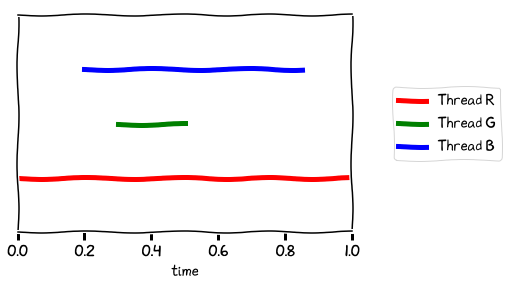

In [11]:
plt.figure(figsize=(6, 4))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('time')
plt.axhline(0.25, 0.0, 1.0, color='r', linewidth=5, label='Thread R')
plt.axhline(0.50, 0.3, 0.5, color='g', linewidth=5, label='Thread G')
plt.axhline(0.75, 0.2, 0.85, color='b', linewidth=5, label='Thread B')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.gca().get_yaxis().set_visible(False)

In Python, threads are concurrent, not parallel.  Using threads in Python will not speed up a program that does a lot of CPU heavy operations, but can speed up programs that do a lot of IO.

Many IO functions in Python, such as working with files or the network, are implemented so that they signal to the Python runtime when they are busy.  Otherwise, functions implemented in C do not yield to the interpreter's thread scheduler.  For pure Python functions, the exact version of Python determines when a thread will be paused to allow other threads to run.

# The `threading` module

The easiest way to interact with threads in Python is with the `threading` module.  The main object in this API is `Thread`, and can be used in one of two ways:

1. Inheriting from `Thread` and overloading the `run` method.
2. Passing a function and arguments to the `Thread` constructor.

In [15]:
import threading
import requests

In [23]:
# Inheritance example

class FetchURL(threading.Thread):
    def __init__(self, url):
        super().__init__()
        self.url = url
    
    def run(self):
        print('Starting fetch')
        result = len(requests.get(self.url).text)
        print('Result: {}'.format(result))

FetchURL('https://reddit.com').start()

Starting fetch
Result: 1064


In [25]:
# Functional example

def fetch_url(url):
    print('Starting fetch')
    result = len(requests.get(url).text)
    print('Result: {}'.format(result))

threading.Thread(
    target=fetch_url,              # Pass the function here, do not call it
    args=('https://reddit.com',),  # Very important that args is a tuple
).start()

Starting fetch
Result: 1064


When to use each style is up to you.  They are pretty much equivalent.

I find that inheriting is usually the best way to go for larger, more
important threads. There are additional arguments that can be passed to
`threading.Thread`, such as `daemon` and `name` that you may want to
have set to specific values for those threads.  This can be specified in
the call to `super().__init__`.

It is also very useful when you want to be able to get a value out of a
thread:

```python
class FetchURL(threading.Thread):
    def __init__(self, url):
        super().__init__()
        self.url = url
        self.result = None

    def run(self):
        self.result = requests.get(url)

fetch = FetchURL('https://reddit.com')
fetch.start()
while fetch.is_alive():
    update_progress_bar()
    time.sleep(0.1)
fetch.join()
print(fetch.result)
```

The functional style is often nicer for quick, one-offs. I often use these
for "fire-and-forget" functions.


## Communicating between threads

Communication between threads should be done with care. Most objects
in Python are not thread safe. This means that operations like

```python
if resource_manager.is_resource_available():
    resource = resource_manager.acquire_resource()
    use_resource(resource)
    resource_manager.release_resource()
```

could run into problems if multiple threads are trying to acquire and
release resources at the same time.  Even more simply, operations like
`x += 1` are not considered atomic, is is interpreted into more than one
instruction by the Python runtime (a fetch, an increment, then a set) so
even performing this simple action on the same value from multiple 
threads can result in a race condition and you will get the wrong result.

The `threading` module provides a number of low level tools for cooperative
threads.  The simplest ones are `Lock`, `RLock`, and `Event`.

## `threading.Lock`

`threading.Lock` is a simple object that makes it easy to indicate if a particular resource is in use.  It implements the context manager interface, making it almost trivial to use:

In [40]:
x = 0

def incr_unsafe():
    global x
    for _ in range(10000):
        x += 1

ts = [threading.Thread(target=incr_unsafe) for _ in range(200)]
[t.start() for t in ts]
[t.join() for t in ts]
print(x)

2001358


In [41]:
x = 0

def incr_safe(lock: threading.Lock):
    global x
    for _ in range(10000):
        with lock:
            x += 1

l = threading.Lock()
ts = [threading.Thread(target=incr_safe, args=(l,)) for _ in range(200)]
[t.start() for t in ts]
[t.join() for t in ts]
print(x)

2000000


Option 2 is significantly slower (from acquiring and releasing the lock each iteration) but it does produce the correct result!

## `threading.RLock`

The `RLock` class is very similar to `Lock`, except it can be entered repeated within the same thread.  This is very useful for something like

```python
class MyFrobinator:
    def __init__(self):
        self._lock = threading.RLock()

    def foo(self):
        with self._lock:
            pass
            
    def bar(self):
        with self._lock:
            pass
                
    def baz(self):
        pass
                
    def foobarbaz(self):
        with self._lock:
            self.foo()
            self.bar()
            self.baz()
```

It can be nested an arbitrary number of times, so you can build classes that are very locked down without doing a lot of bookkeeping.

## threading.Event

A `threading.Event` is an object that acts as a thread-safe boolean flag that you can wait on.  A simple example:

In [42]:
def thread1(evts):
    for evt in evts:
        time.sleep(1)
        evt.set()

def thread2(evts):
    for i, evt in enumerate(evts, 1):
        evt.wait()
        print(i)

evts = [threading.Event() for _ in range(5)]
threading.Thread(target=thread1, args=(evts,)).start()
threading.Thread(target=thread2, args=(evts,)).start()

1
2
3
4
5


The `wait` method takes an optional timeout, and an event can be reused by calling `.clear` on it.  The current status of an event can also be checked with `is_set`.

##  Using `queue` to communicate

# The `multiprocessing` module

## `multiprocessing.Process`

## `multiprocessing.Pool`

## `multiprocessing.Queue`

## `multiprocessing.dummy`

# Difficulties in using directly

# Alternatives to the standard library

## `dask`


## `ipyparallel`

## Communication with `zmq`

# Best practices

# Recap

# Questions?